## Лабораторна робота №3
## Виконав ст. групи КМ-01
## Шолоп Любомир
## Варіант 4 (21)
*Розпізнавання мережевої кібератаки типу teardrop на базі PNN*

### Імпортуємо бібліотеки

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, average_precision_score, confusion_matrix

### Створюємо клас мережі PNN

In [2]:
class PNN:
    def __init__(self, input_size, output_size):
        """
        Ініціалізація параметрів моделі PNN.

        Parameters:
        - input_size (int): Розмір вхідного вектора.
        - output_size (int): Кількість вихідних класів.
        """
        self.input_size = input_size
        self.output_size = output_size
        self.mean_vectors = None
        self.sigma = None
        self.weights = None


    def predict(self, X_train, X_test, y, sigma=1.0):
        """
        Здійснює прогноз за допомогою моделі PNN.

        Parameters:
        - X_train (numpy.ndarray): Масив навчальних даних.
        - X_test (numpy.ndarray): Масив тестових даних.
        - y (numpy.ndarray): Вектор міток класів для навчальних даних.
        - sigma (float): Параметр розподілу Гаусса для визначення ширини ядра.

        Returns:
        - numpy.ndarray: Вектор прогнозованих класів.
        """
        self.mean_vectors = []

        # Обчислюємо середні вектори для кожного класу
        for class_label in range(self.output_size):
            class_samples = X_train[y == class_label]
            mean_vector = np.mean(class_samples, axis=0)
            self.mean_vectors.append(mean_vector)

        self.mean_vectors = np.array(self.mean_vectors)

        # Обчислюємо ваги для кожного класу
        self.weights = np.ones(self.output_size) / self.output_size
        predictions = []

        for sample in X_test:
            probabilities = []

            # Розраховуємо ймовірності для кожного класу
            for class_label in range(self.output_size):
                mean_vector = self.mean_vectors[class_label]
                sample = sample.astype(float)
                activation = np.exp(-0.5 * np.sum((sample - mean_vector) ** 2) / (sigma ** 2))
                probability = activation * self.weights[class_label]
                probabilities.append(probability)

            # Визначаємо клас з найвищою ймовірністю
            predicted_class = np.argmax(probabilities)
            predictions.append(predicted_class)

        return np.array(predictions)

### Завантажимо датасет NLS-KDD

In [3]:
train_data = pd.read_csv('KDDTrain+.txt')
test_data = pd.read_csv('KDDTest+.txt')

columns = (['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot',
            'num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root',
            'num_file_creations','num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login',
            'count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate',
            'diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate',
            'dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate',
            'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','attack','level'])

train_data.columns = columns
test_data.columns = columns

# Поєднання двох датафреймів
combined_data = pd.concat([train_data, test_data], axis=0)

# Розділення за типом атаки
attack_data = combined_data[combined_data['attack'] == 'teardrop']
normal_data = combined_data[combined_data['attack'] == 'normal']

# Розбиття на навчальний та тестовий набір
train_attack, test_attack = train_test_split(attack_data, test_size=0.3, random_state=42)
train_normal, test_normal = train_test_split(normal_data, test_size=0.3, random_state=42)

# Об'єднання навчальних та тестових наборів
train_data = pd.concat([train_attack, train_normal], axis=0)
test_data = pd.concat([test_attack, test_normal], axis=0)

# Виведення розмірів навчального та тестового наборів
print(f'Розмір навчального набору: {train_data.shape[0]}')
print(f'Розмір тестового набору: {test_data.shape[0]}')

Розмір навчального набору: 54569
Розмір тестового набору: 23388


### Подивимось скільки шуканих атак у наборах даних

In [4]:
count_train_teardrop = (train_data['attack'] == 'teardrop').sum()
count_train_normal = (train_data['attack'] == 'normal').sum()
count_test_teardrop = (test_data['attack'] == 'teardrop').sum()
count_test_normal = (test_data['attack'] == 'normal').sum()

print(f"Записів із 'teardrop' у навчальному наборі: {count_train_teardrop}")
print(f"Записів із 'normal' у навчальному наборі: {count_train_normal}\n")
print(f"Записів із 'teardrop' у тестовому наборі: {count_test_teardrop}")
print(f"Записів із 'normal' у тестовому наборі: {count_test_normal}")

Записів із 'teardrop' у навчальному наборі: 632
Записів із 'normal' у навчальному наборі: 53937

Записів із 'teardrop' у тестовому наборі: 272
Записів із 'normal' у тестовому наборі: 23116


### Лишаємо записи, де тип атаки 'teardrop' , 'normal'

In [5]:
train_data = train_data[(train_data['attack'] == 'teardrop') | (train_data['attack'] == 'normal')]
test_data  = test_data[ (test_data['attack']  == 'teardrop') | (test_data['attack']  == 'normal')]

### Подивимось типи кожної колонки

In [6]:
train_data.dtypes  #  датафрейм test_data містить такі самі колонки та типи

duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

### Колонка 'attack' - це колонка міток, її треба перекодувати

### Перекодуємо категорійні значення

In [7]:
# Використання one-hot encoding для категорійних змінних
filtered_train_data = pd.get_dummies(train_data, drop_first=True)
filtered_test_data  = pd.get_dummies(test_data,  drop_first=True)

### Подивимось розмірності наборів даних
Після перекодування категорійних даних можуть виникати зайві колонки  
Подивимось чи у нашому випадку такі будуть

In [8]:
print(f'Колонок у навчальному наборі: {filtered_train_data.shape[1]}')
print(f'Колонок у тестовому наборі: {filtered_test_data.shape[1]}')

# Отримання назв колонок для обох датафреймів
columns_train = set(filtered_train_data.columns)
columns_test = set(filtered_test_data.columns)
common_columns = columns_train.intersection(columns_test)  # Знаходження спільних назв колонок
print('Кількість спільних колонок:', len(common_columns))

# Знаходження унікальних колонок у кожному датафреймі
unique_columns_train = columns_train.difference(columns_test)
unique_columns_test = columns_test.difference(columns_train)

# Виведення назв унікальних колонок у кожному датафреймі
print(f'\nУнікальні колонки в навчальному наборі: {unique_columns_train}')
print(f'Унікальні колонки в тестовому наборі: {unique_columns_test}')

Колонок у навчальному наборі: 78
Колонок у тестовому наборі: 77
Кількість спільних колонок: 76

Унікальні колонки в навчальному наборі: {'flag_RSTOS0', 'service_link'}
Унікальні колонки в тестовому наборі: {'service_remote_job'}


### Отже, назви та кількість не співпадають
Тепер подивимось кількість цих даних

In [9]:
service_link = (train_data['service'] == 'link').sum()
flag_RSTOS0 = (train_data['flag'] == 'RSTOS0').sum()
service_remote_job = (test_data['service'] == 'remote_job').sum()

print(f"Кількість входжень 'link' у навчальному наборі: {service_link}")
print(f"Кількість входжень 'RSTOS0' у навчальному наборі: {flag_RSTOS0}")
print(f"Кількість входжень 'remote_job' у тестовому наборі: {service_remote_job}")

Кількість входжень 'link' у навчальному наборі: 1
Кількість входжень 'RSTOS0' у навчальному наборі: 1
Кількість входжень 'remote_job' у тестовому наборі: 1


### Видаляємо дані

In [10]:
train_data = train_data[(train_data['service'] != 'link') & (train_data['flag'] != 'RSTOS0')]
test_data = test_data[(test_data['service'] != 'remote_job')]

### Знову перекодуємо дані та подивимость кількість спільних назв серед колонок

In [11]:
filtered_train_data = pd.get_dummies(train_data, drop_first=True)
filtered_test_data  = pd.get_dummies(test_data,  drop_first=True)

print(f'Колонок у навчальному наборі: {filtered_train_data.shape[1]}')
print(f'Колонок у тестовому наборі: {filtered_test_data.shape[1]}')

# Отримання назв колонок для обох датафреймів
columns_train = set(filtered_train_data.columns)
columns_test = set(filtered_test_data.columns)

common_columns = columns_train.intersection(columns_test)  # Знаходження спільних назв колонок
print('Кількість спільних колонок:', len(common_columns))

Колонок у навчальному наборі: 76
Колонок у тестовому наборі: 76
Кількість спільних колонок: 76


### Тепер обидва датафрейми мають однакові назви колонок

### Після перекодування колонка 'attack' має назву 'attack_teardrop'

In [12]:
print(filtered_test_data.columns[-1])

attack_teardrop


### Нормалізація даних

In [13]:
scaler = MinMaxScaler()

new_columns = filtered_train_data.columns

filtered_train_data[new_columns] = scaler.fit_transform(filtered_train_data[new_columns])
filtered_test_data[new_columns] = scaler.transform(filtered_test_data[new_columns])

### Розбиття на X_train, X_test, y_train, y_test

In [14]:
X_train = filtered_train_data.drop(columns=['attack_teardrop'])
y_train = filtered_train_data['attack_teardrop']

X_test = filtered_test_data.drop(columns=['attack_teardrop'])
y_test = filtered_test_data['attack_teardrop']

### Створимо об'єкт класу PNN із вхідними параметрами:  
- input_size=76
- output_size=2

In [15]:
input_size = filtered_train_data.shape[1]
output_size = 2  # розмірність вихідного шару (два класи)

pnn = PNN(input_size, output_size)

### Тестування моделі

In [16]:
sigma_value = 0.03
# sigma_value = 1.0
predictions = pnn.predict(X_train, X_test.values, y_train, sigma_value)

### Оцінка моделі

In [17]:
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f"Accuracy (Точність) : {round(accuracy * 100, 5)} %")
print(f"Precision (Точність) : {round(precision * 100, 5)} %")
print(f"Recall (Повнота) : {round(recall * 100, 5)} %")
print(f"F1 Score (F-міра) : {round(f1 * 100, 5)} %")

Accuracy (Точність) : 99.86317 %
Precision (Точність) : 92.85714 %
Recall (Повнота) : 95.58824 %
F1 Score (F-міра) : 94.2029 %


### Побудуємо PR-криву


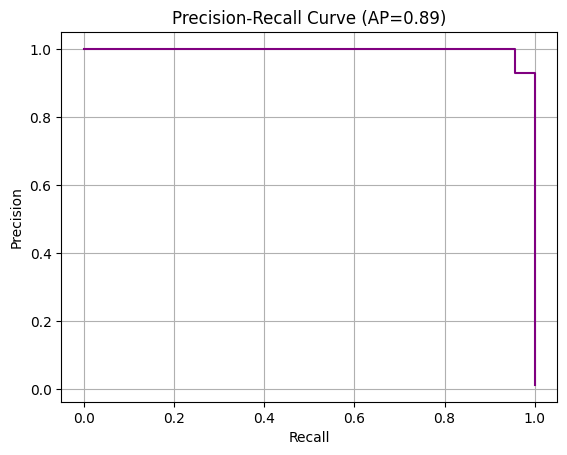

In [18]:
precision, recall, _ = precision_recall_curve(y_test, predictions)
average_precision = average_precision_score(y_test, predictions)

plt.figure()
plt.step(recall, precision, color='purple')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (AP={:.2f})'.format(average_precision))
plt.grid()
plt.show()


### Побудуємо матрицю помилок із результатами дослідження

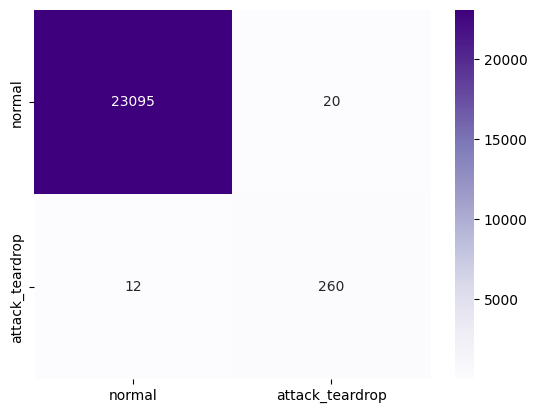

In [19]:
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
            xticklabels=['normal', 'attack_teardrop'],
            yticklabels=['normal', 'attack_teardrop'])
plt.show()